In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import layers


In [7]:
ds1,ds2,ds3 = tfds.load('patch_camelyon:2.0.0',split=['train[:10%]','test[:3%]','validation[:3%]'],
                        data_dir = r'C:\Users\maria\OneDrive\Skrivebord\3. semester\Anvendt maskinlæring\Exam',
                        download=False,
                        shuffle_files=True)

In [9]:
#Konverterer en enkelt sample fra et datasæt til det format, der er nødvendigt for træning af en autoencoder.

def convert_sample(sample):
    image = sample['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Returner billedet som både input og label



In [10]:
# Map and batch the datasets
train_dataset = ds1.map(convert_sample).batch(64)
validation_dataset = ds3.map(convert_sample).batch(64)
test_dataset = ds2.map(convert_sample).batch(64)


In [11]:
latent_dim = 128

# Encoder
encoder_input = Input(shape=(96, 96, 3), name='encoder_input')
x = Conv2D(512, (3, 3), activation='relu', padding='same', strides=2)(encoder_input)
x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Reparameterization trick to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Encoder Model
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')


# Decoder
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(12 * 12 * 16, activation='relu')(latent_inputs)
x = Reshape((12, 12, 16))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(512, (3, 3), activation='relu', padding='same', strides=2)(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


# Decoder Model
decoder = Model(latent_inputs, decoded, name='decoder')

# VAE Model
outputs = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, outputs, name='vae')


In [12]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 48, 48, 512)  14336       ['encoder_input[0][0]']          
                                                                                                  
 conv2d_4 (Conv2D)              (None, 24, 24, 256)  1179904     ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 12, 12, 128)  295040      ['conv2d_4[0][0]']               
                                                                                            

In [14]:
# Loss function
reconstruction_loss = mean_squared_error(K.flatten(encoder_input), K.flatten(outputs))
reconstruction_loss *= 96 * 96 * 3
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [15]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [16]:
# Definer early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [17]:
# Training
history = vae.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=[early_stopping])


Epoch 1/10
410/410 [==============================] - 3952s 10s/step - loss: 1121.8063 - val_loss: 1084.3284
Epoch 2/10
410/410 [==============================] - 3432s 8s/step - loss: 989.0150 - val_loss: 1050.0653
Epoch 3/10
410/410 [==============================] - 3657s 9s/step - loss: 962.8094 - val_loss: 1028.4519
Epoch 4/10
410/410 [==============================] - 3820s 9s/step - loss: 944.2459 - val_loss: 995.0342
Epoch 5/10
410/410 [==============================] - 3468s 8s/step - loss: 915.2111 - val_loss: 1005.9900
Epoch 6/10
410/410 [==============================] - 4585s 11s/step - loss: 905.9214 - val_loss: 978.5173
Epoch 7/10
410/410 [==============================] - 5831s 14s/step - loss: 900.6166 - val_loss: 975.1892
Epoch 8/10
410/410 [==============================] - 5736s 14s/step - loss: 897.3765 - val_loss: 966.7739
Epoch 9/10
410/410 [==============================] - 5262s 13s/step - loss: 892.3604 - val_loss: 964.1423
Epoch 10/10
410/410 [===============

In [18]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



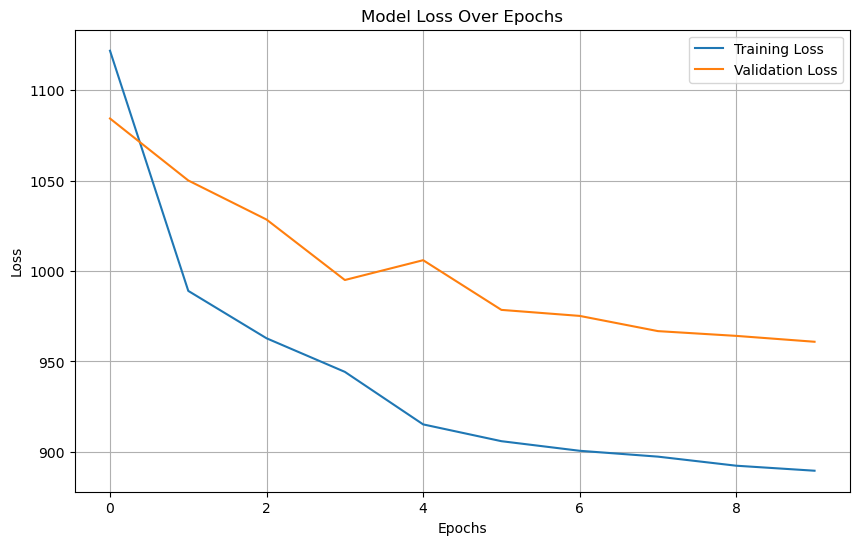

In [19]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

In [20]:
# Evaluate Variational Autoencoder
mse_vae = vae.evaluate(validation_dataset)

print("MSE for Autoencoder:", vae)

16/16 [==============================] - 55s 3s/step - loss: 960.8253
MSE for Autoencoder: <keras.engine.functional.Functional object at 0x00000267F398E530>


In [21]:
# Evaluate Variational Autoencoder
mse_vae = vae.evaluate(test_dataset)

print("MSE for Autoencoder:", vae)

16/16 [==============================] - 46s 3s/step - loss: 890.1284
MSE for Autoencoder: <keras.engine.functional.Functional object at 0x00000267F398E530>


In [22]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



In [23]:
def plot_reconstructions(vae, dataset, num_images=5):
    # Hent nogle eksempler fra datasettet
    sample_images = next(iter(dataset))[0][:num_images]

    # Få autoencoderens rekonstruktioner
    reconstructed_images = vae.predict(sample_images)

    # Plot originaler og rekonstruktioner
    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        # Originalbillede
        plt.subplot(2, num_images, i + 1)
        plt.imshow(sample_images[i])
        plt.title("Original")
        plt.axis("off")

        # Rekonstrueret billede
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Rekonstruktion")
        plt.axis("off")

    plt.show()



In [24]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



1/1 [==============================] - 2s 2s/step


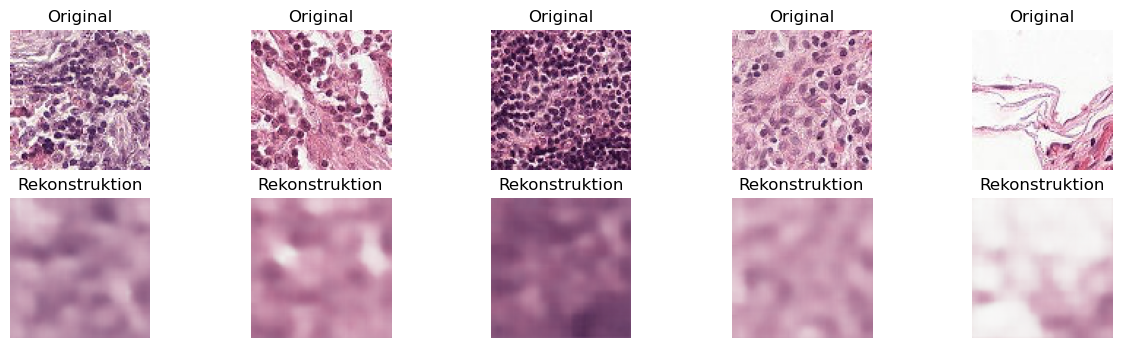

In [25]:
# Anvend funktionen på validationsæt
plot_reconstructions(vae, validation_dataset)

In [26]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



1/1 [==============================] - 1s 665ms/step


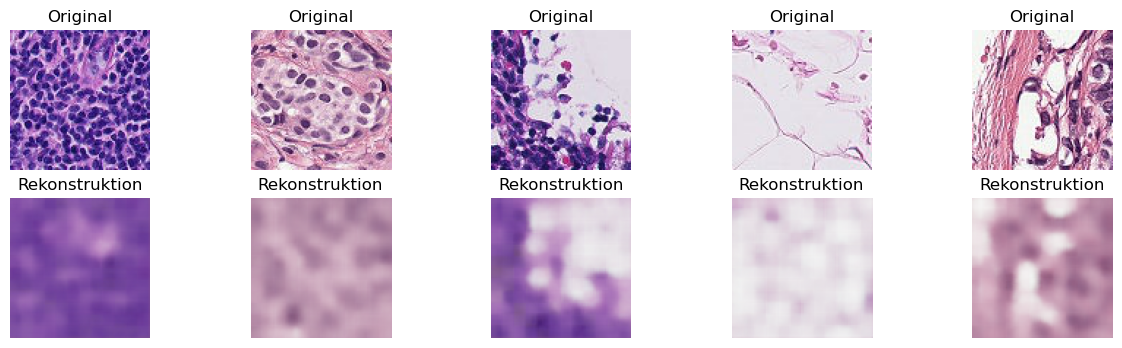

In [27]:
# Anvend funktionen på testsæt
plot_reconstructions(vae, test_dataset)

In [28]:
# Forberedelse af datasæt til klassifikation
def prepare_classification_dataset(sample):
    image, label = sample['image'], sample['label']
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, depth=2)  # Antager 2 klasser
    return image, label

In [29]:
# Map og batch datasæt
train_dataset_cls = ds1.map(prepare_classification_dataset).batch(32)
validation_dataset_cls = ds3.map(prepare_classification_dataset).batch(32)
test_dataset_cls = ds2.map(prepare_classification_dataset).batch(32)

In [30]:
# Skil data og labels ad
def extract_images_and_labels(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.append(image_batch)
        labels.append(label_batch)
    return tf.concat(images, axis=0), tf.concat(labels, axis=0)

x_train, y_train = extract_images_and_labels(train_dataset_cls)
x_val, y_val = extract_images_and_labels(validation_dataset_cls)
x_test,y_test = extract_images_and_labels(test_dataset_cls)

In [31]:
# Få outputtet fra encoderen
encoder_output = encoder(encoder_input)

z_mean = encoder_output[0] if isinstance(encoder_output, list) else encoder_output

# Tilføj ekstra lag for klassifikation
x = Flatten()(z_mean)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)  # Antager binær klassifikation

# Byg hele modellen
classifier = Model(inputs=encoder_input, outputs=output)

# Kompiler klassifikatoren
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [32]:
# Træn klassifikationsmodellen med mærket data
CNNmodel = classifier.fit(
    x_train, y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(x_val, y_val)  
)

Epoch 1/10


820/820 [==============================] - 861s 1s/step - loss: 0.5422 - accuracy: 0.7376 - val_loss: 0.4717 - val_accuracy: 0.7609
Epoch 2/10
820/820 [==============================] - 673s 821ms/step - loss: 0.4837 - accuracy: 0.7798 - val_loss: 0.4622 - val_accuracy: 0.7772
Epoch 3/10
820/820 [==============================] - 666s 812ms/step - loss: 0.4609 - accuracy: 0.7921 - val_loss: 0.4930 - val_accuracy: 0.7691
Epoch 4/10
820/820 [==============================] - 520s 634ms/step - loss: 0.4337 - accuracy: 0.8057 - val_loss: 0.4289 - val_accuracy: 0.7976
Epoch 5/10
820/820 [==============================] - 463s 564ms/step - loss: 0.4105 - accuracy: 0.8172 - val_loss: 0.4391 - val_accuracy: 0.8026
Epoch 6/10
820/820 [==============================] - 466s 568ms/step - loss: 0.3714 - accuracy: 0.8389 - val_loss: 0.4923 - val_accuracy: 0.7792
Epoch 7/10
820/820 [==============================] - 462s 564ms/step - loss: 0.3389 - accuracy: 0.8534 - val_loss: 0.5066 - val_accuracy:

Evaluering af Klassifikationsmodellen

In [33]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


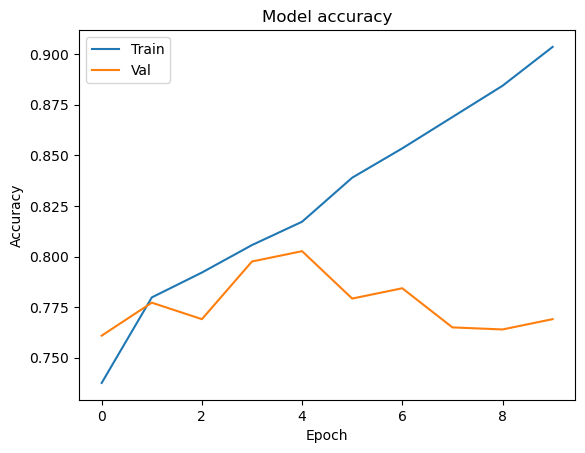

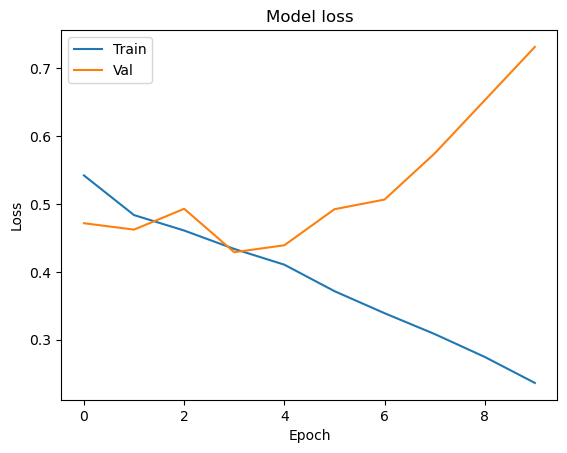

In [34]:
# Plot training & validation accuracy values
plt.plot(CNNmodel.history['accuracy'])
plt.plot(CNNmodel.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNNmodel.history['loss'])
plt.plot(CNNmodel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [35]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Confusionmatrix

In [37]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


31/31 [==============================] - 5s 168ms/step


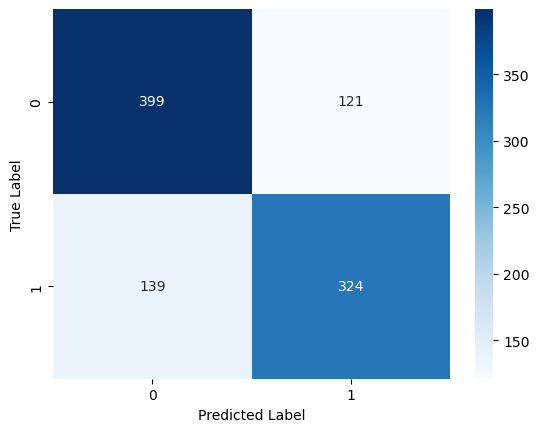

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, x_data, y_true):
    y_pred = model.predict(x_data).argmax(axis=1)
    y_true = np.argmax(y_true, axis=1)  # Convert y_true to NumPy array
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Call the function
plot_confusion_matrix(classifier, x_test, y_test)


ROC Kurve

In [39]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'



31/31 [==============================] - 5s 159ms/step


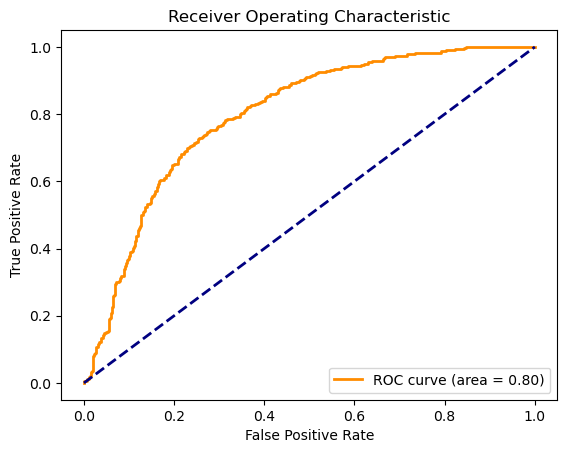

In [40]:
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import matplotlib.pyplot as plt

y_pred_prob = classifier.predict(x_test)[:, 1]  # Forudsigelse af sandsynligheder for klasse 1

# Brug tf.argmax til TensorFlow tensors og konverter til numpy array
y_true = tf.argmax(y_test, axis=1).numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()